In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
# nltk.download()

## Load transcript file and concatenate
There are two parts for the Debate 1

In [2]:
transcript_1 = pd.read_csv("dataset/parsed_transcript_1_p1.csv")
transcript_2 = pd.read_csv("dataset/parsed_transcript_1_p2.csv")

In [3]:
transcript = pd.concat([transcript_1, transcript_2], ignore_index=True)
transcript.head()

,name,time,contents
0,Chris Wallace,01:20,Good evening from the Health Education Campus ...
1,Chris Wallace,02:10,This debate is being conducted under health an...
2,Vice President Joe Biden,02:49,"How you doing, man?"
3,President Donald J. Trump,02:51,How are you doing?
4,Vice President Joe Biden,02:51,I’m well.


## Use VaderSentiment Package
VaderSentiment gives the score for positivity, negativity, and neutral.
Also, The compound score is computed by summing the score of each word and then normalizing.
We define a function called `vader_polarity` to convert the positivity/negativity/neutral score to ternary value.
-1 if negativity dominates, 0 if neutral dominates, and 1 if positivity dominates.
Also, this function returns a compound score as well.

In [4]:
analyser = SentimentIntensityAnalyzer()


def vader_polarity(text):
    """
    Transform the output to a -1/0/1
    """
    score = analyser.polarity_scores(text)
    if max(score.values()) == score['pos']:
        return 1, score['compound']
    elif max(score.values()) == score['neu']:
        return 0, score['compound']
    else:
        return -1, score['compound']


## Save computed scores to the new columns

In [5]:
for index, row in transcript.iterrows():
    text = row['contents']
    transcript.loc[index, 'scores'], transcript.loc[index, 'compound_scores'] = vader_polarity(text)

In [6]:
transcript.head()

,name,time,contents,scores,compound_scores
0,Chris Wallace,01:20,Good evening from the Health Education Campus ...,0.0,0.8957
1,Chris Wallace,02:10,This debate is being conducted under health an...,-1.0,0.8661
2,Vice President Joe Biden,02:49,"How you doing, man?",0.0,0.0000
3,President Donald J. Trump,02:51,How are you doing?,0.0,0.0000
4,Vice President Joe Biden,02:51,I’m well.,1.0,0.2732


## Data analysis with the visualization

In [7]:
%matplotlib inline
transcript = transcript.set_index('time')

Text(0, 0.5, 'Count')

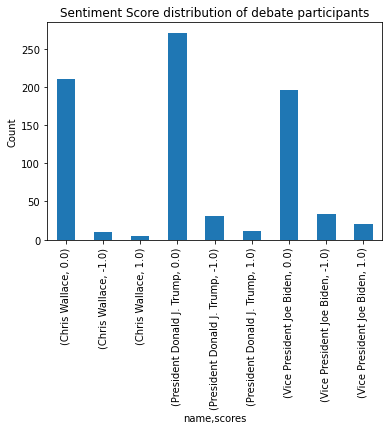

In [8]:
transcript.groupby('name')['scores'].value_counts().plot(kind='bar')
plt.title('Sentiment Score distribution of debate participants')
plt.ylabel('Count')

Text(0, 0.5, 'Sentiment Polarity')

<Figure size 3000x2000 with 0 Axes>

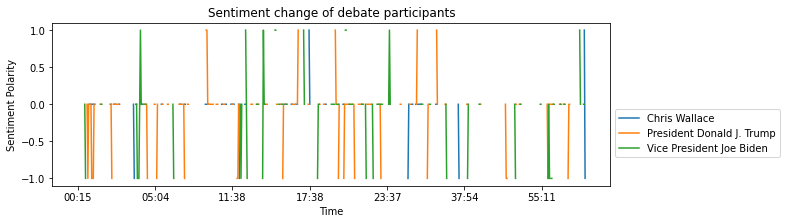

In [9]:
fig = plt.figure(dpi=500)
pd.pivot_table(transcript.reset_index(),
               index='time', columns='name', values='scores'
              ).plot(figsize=(10,3), subplots=False, legend=True)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.title('Sentiment change of debate participants')
plt.xlabel('Time')
plt.ylabel('Sentiment Polarity')

Text(0, 0.5, 'Compound Score')

<Figure size 432x288 with 0 Axes>

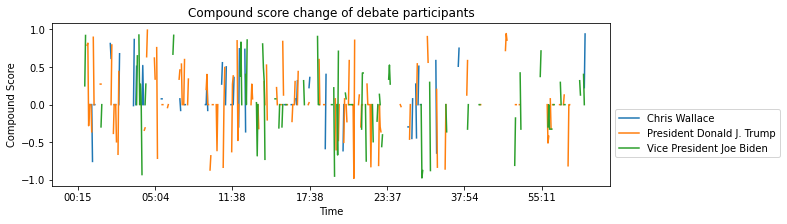

In [10]:
fig = plt.figure()
pd.pivot_table(transcript.reset_index(),
               index='time', columns='name', values='compound_scores'
              ).plot(figsize=(10,3), subplots=False, legend=True)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.title('Compound score change of debate participants')
plt.xlabel('Time')
plt.ylabel('Compound Score')

Text(0, 0.5, 'Compound Score')

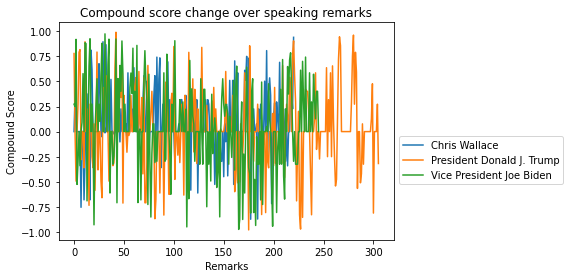

In [11]:
fig = plt.figure()
compound_score_pivot = pd.pivot_table(transcript.reset_index(), index='time', columns='name', values='compound_scores')
cw = compound_score_pivot['Chris Wallace'].dropna()
plt.plot(cw.to_list())
dt = compound_score_pivot['President Donald J. Trump'].dropna()
plt.plot(dt.to_list())
jb = compound_score_pivot['Vice President Joe Biden'].dropna()
plt.plot(jb.to_list())
plt.legend(['Chris Wallace', 'President Donald J. Trump', 'Vice President Joe Biden'],
           loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.title('Compound score change over speaking remarks')
plt.xlabel('Remarks')
plt.ylabel('Compound Score')

Text(0, 0.5, 'Compound Score')

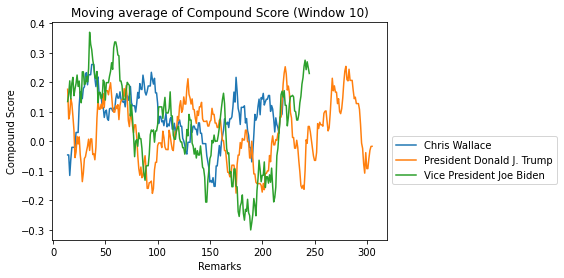

In [13]:
fig = plt.figure()
plt.plot(cw.rolling(window=10).mean().to_list())
plt.plot(dt.rolling(window=10).mean().to_list())
plt.plot(jb.rolling(window=10).mean().to_list())
plt.legend(['Chris Wallace', 'President Donald J. Trump', 'Vice President Joe Biden'],
           loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.title('Moving average of Compound Score (Window 10)')
plt.xlabel('Remarks')
plt.ylabel('Compound Score')


## Find correlation of sentimental changes between two candidates
We can conclude that the sentiment between two candidates has a weak correlation,
but it is strong than Chris Wallace's emotional status.

In [20]:
print(dt.rolling(window=10).mean().corr(jb.rolling(window=10).mean()))
print(dt.rolling(window=10).mean().corr(cw.rolling(window=10).mean()))

0.24950134679771652
-0.01888386960201964
